In [1]:
import numpy as np
from numpy.random import default_rng
from time import time
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model  
import random

In [1]:
pip install statsmodels

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 40.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 37.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Test 1

In [50]:
# random seed
random.seed(12333)
# Dimension
# Simple case (Equal sample size)
n_0 = 500; n_1= 500; p = 500
# True parameters
sigma2 = np.array([1,1])
#beta = np.ones((p,1))/(beta.T.dot(beta))**0.5
beta = np.random.normal(0,1,(p,1))
beta = beta/(beta.T.dot(beta))**0.5
# Covariance Matrix of X
mean = np.zeros(p)
rho = 0.5
i, j = np.mgrid[:p, :p]
cov = rho**abs(i-j)

In [46]:
def simulator(n, p, beta, mean, cov, sigma2, seed):
    
    
    rng = default_rng(seed)
    #X = rng.multivariate_normal(mean, cov, (n,), 'raise')
    d = 3
    B = np.random.normal(0,0.5,(p,d))
    Z=rng.normal(0,1,(n,d)).reshape(n,d)
    error = rng.normal(0,sigma2**0.5,(n,p))
    X=Z@B.T + error
    #X = rng.multivariate_normal(mean,np.eye(p),(n,))
    error = rng.normal(0,sigma2**0.5,n).reshape((n,1))
    Y = X.dot(beta) + error

    return X,Y,error

In [8]:
def simulator_Pareto(n, p, beta, sigma2, seed):
    
    rng = default_rng(seed)
    #X = rng.binomial(n=5, p=0.5, size=(n,p))
    #X = rng.f(dfnum=1, dfden=2, size=(n,p))
    X = rng.gamma(2, 2,size=(n,p))
    #X = rng.pareto(2,size=(n,p))
    error = rng.normal(0,sigma2**0.5,n).reshape((n,1))
    Y = X.dot(beta) + error

    return X,Y,error

In [39]:
# Data Generation
X_0, Y_0, Err_0 = simulator(n_0, p, beta, mean, cov, sigma2[0],122)
X_1, Y_1, Err_1 = simulator(n_1, p, beta, mean, cov, sigma2[1],166)

In [51]:
def regression_j(nn, Y, Xj):
    
    Xj = Xj.reshape((nn,1))
    Y = Y.reshape((nn,1))
    gammaj_h = Xj.T@Y/(Xj.T@Xj)
    etaj_h = Y - Xj*gammaj_h[0][0]
    sigmaj2_h = etaj_h.T@etaj_h/(nn - 1)
    
    return gammaj_h[0][0], etaj_h.reshape(nn), sigmaj2_h[0][0]

In [52]:
# Working model
gamma0_hat = np.zeros(p)
gamma1_hat = np.zeros(p)
gamma_star_hat = np.zeros(p)
eta0_hat = np.zeros((n_0,p))
eta1_hat = np.zeros((n_1,p))
eta_star_hat = np.zeros((n_0+n_1,p))
sigma02_hat = np.zeros(p)
sigma12_hat = np.zeros(p)
sigma2_star_hat = np.zeros(p)
for j in range(p):
    gamma0_hat[j], eta0_hat[:,j], sigma02_hat[j] = regression_j(n_0, Y_0, X_0[:,j])
    #print(gamma0_hat[j],sigma02_hat[j])
    gamma1_hat[j], eta1_hat[:,j], sigma12_hat[j] = regression_j(n_1, Y_1, X_1[:,j])
    #print(gamma1_hat[j],sigma12_hat[j])
    gamma_star_hat[j], eta_star_hat[:,j], sigma2_star_hat[j] = regression_j(n_0+n_1, np.append(Y_0,Y_1), np.append(X_0[:,j], X_1[:,j]))

In [53]:
# Computing the test statistics
T = np.mean(np.log(sigma02_hat/sigma12_hat))
VarQa = np.var(np.mean((eta0_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_0+np.var(np.mean((eta1_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_1

In [54]:
T/(VarQa**0.5)

1.8925835862139033

In [17]:
def map_fun(b,n_0,n_1):
    
    X_0, Y_0, Err_0 = simulator(n_0, p, beta, mean, cov, sigma2[0], seed=b)
    X_1, Y_1, Err_1 = simulator(n_1, p, beta, mean, cov, sigma2[1], seed=b+8888)
    # Data Generation--Pareto
    #X_0, Y_0, Err_0 = simulator_Pareto(n_0, p, beta, sigma2[0],seed=b)
    #X_1, Y_1, Err_1 = simulator_Pareto(n_1, p, beta, sigma2[1],seed=b+8888)
    
    # Working model
    gamma0_hat = np.zeros(p)
    gamma1_hat = np.zeros(p)
    gamma_star_hat = np.zeros(p)
    eta0_hat = np.zeros((n_0,p))
    eta1_hat = np.zeros((n_1,p))
    eta_star_hat = np.zeros((n_0+n_1,p))
    sigma02_hat = np.zeros(p)
    sigma12_hat = np.zeros(p)
    sigma2_star_hat = np.zeros(p)
    for j in range(p):
        gamma0_hat[j], eta0_hat[:,j], sigma02_hat[j] = regression_j(n_0, Y_0, X_0[:,j])
        gamma1_hat[j], eta1_hat[:,j], sigma12_hat[j] = regression_j(n_1, Y_1, X_1[:,j])
        gamma_star_hat[j], eta_star_hat[:,j], sigma2_star_hat[j] = regression_j(n_0+n_1, np.append(Y_0,Y_1), np.append(X_0[:,j], X_1[:,j]))
    
    # Computing the test statistics
    T = np.mean(np.log(sigma02_hat/sigma12_hat))
    #print(sigma02_hat[0],sigma12_hat[0])
    VarQa = np.var(np.mean((eta0_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_0+np.var(np.mean((eta1_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_1

    T_star = T/(VarQa**0.5)
    print(T_star,T,VarQa)
    
    return T_star 

In [55]:
n_0 = 500; n_1=500

In [56]:
BB = 500
T_star_n500_n500_p500_B500= np.zeros(BB)
for b in range(BB):
    if b%100==0: print(b)
    T_star_n500_n500_p500_B500[b] = map_fun(b,n_0,n_1) 

0
2.406637295985661 0.18692692476162795 0.006032848746227167
0.7608895923663811 0.06179093070600531 0.006594869192624899
1.5228289278186005 0.1361102587465882 0.007988762000052585
1.5594023266248767 0.13041117509201652 0.006993800837146926
-1.9020122757768452 -0.16207713344838817 0.007261341512915045
-1.1954106663510613 -0.09977480259495981 0.006966385464097969
0.6139866519464573 0.052641555250710056 0.0073508839066037555
-1.3909890828865799 -0.11391443545442999 0.006706718550958902
-0.5418559946954565 -0.04797022878647039 0.007837468613797995
-3.312972976556737 -0.27110948726279116 0.00669658898930761
-4.4231382257348715 -0.35120047840198054 0.006304478595234175
2.1905249516554353 0.19512526787770765 0.007934701905898924
0.957280977569256 0.07757844815171691 0.006567548940900772
-2.421874699568474 -0.20980154748585558 0.007504366460583136
4.038514725107253 0.3402961067253041 0.0071002006081886905
0.8890044076244044 0.07426634574974983 0.0069787281627271365
-0.7634852435535161 -0.06713

In [57]:
len(np.where(np.abs(T_star_n500_n500_p500_B500)>1.96)[0])

250

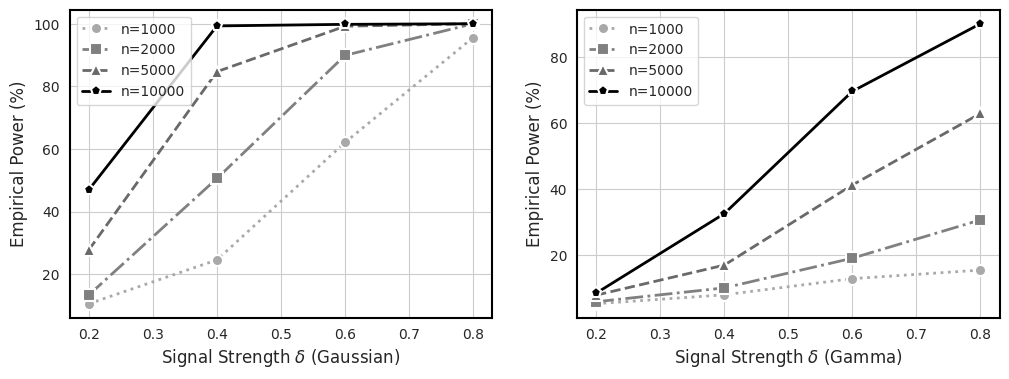

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
# 输入数据
x = [0.2, 0.4, 0.6, 0.8]
y_n1000 = [10.6,24.6,62.1,95.6]
y_n2000 = [13.4,50.6,89.9,100]
y_n5000 = [27.8,84.7,99.2,100]
y_n10000 = [47,99.3,99.8,100]
# 绘图
sns.set_style("whitegrid") # 设置背景样式
sns.lineplot(x=x, y=y_n1000, color='darkgray', linewidth=2.0, linestyle = 'dotted', marker="o", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=1000')
sns.lineplot(x=x, y=y_n2000, color='gray', linewidth=2.0,linestyle = 'dashdot', marker="s", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=2000')
sns.lineplot(x=x, y=y_n5000, color='dimgray', linewidth=2.0,linestyle = 'dashed', marker="^", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=5000')
sns.lineplot(x=x, y=y_n10000, color='black', linewidth=2.0, marker="p", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=10000')

# 添加标题和标签
#plt.title("Title", fontweight='bold', fontsize=14)
plt.xlabel('Signal Strength '+r'$\delta$' + ' (Gaussian)', fontsize=12)
plt.ylabel('Empirical Power (%)', fontsize=12)

# 添加图例
plt.legend(loc='upper left', frameon=True, fontsize=10)

# 设置刻度字体和范围
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlim(0, 6)
#plt.ylim(0, 25)

# 设置坐标轴样式
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

#plt.savefig('power_gamma.pdf')#, bbox_inches='tight'
# 显示图像
#plt.show()


plt.subplot(122)
# 输入数据
x = [0.2, 0.4, 0.6, 0.8]
y_n1000 = [5.3,8,12.9,15.5]
y_n2000 = [5.9,10.1,19.1,30.7]
y_n5000 = [7.9,17,41.3,63]
y_n10000 = [8.5,32.6,69.7,90.2]
# 绘图
sns.set_style("whitegrid") # 设置背景样式
sns.lineplot(x=x, y=y_n1000, color='darkgray', linewidth=2.0, linestyle = 'dotted', marker="o", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=1000')
sns.lineplot(x=x, y=y_n2000, color='gray', linewidth=2.0,linestyle = 'dashdot', marker="s", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=2000')
sns.lineplot(x=x, y=y_n5000, color='dimgray', linewidth=2.0,linestyle = 'dashed', marker="^", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=5000')
sns.lineplot(x=x, y=y_n10000, color='black', linewidth=2.0, marker="p", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=10000')

# 添加标题和标签
#plt.title("Title", fontweight='bold', fontsize=14)
plt.xlabel('Signal Strength '+r'$\delta$' + ' (Gamma)', fontsize=12)
plt.ylabel('Empirical Power (%)', fontsize=12)

# 添加图例
plt.legend(loc='upper left', frameon=True, fontsize=10)

# 设置刻度字体和范围
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlim(0, 6)
#plt.ylim(0, 25)

# 设置坐标轴样式
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.savefig('power.pdf')#, bbox_inches='tight'
# 显示图像
plt.show()

# Test 2

In [327]:
# random seed
random.seed(12333)
# Dimension
# Simple case (Equal sample size)
n_0 = 500; n_1= 500; p = 500; q = 5
# True parameters
sigma2 = np.array([1,0.2])
#beta = np.ones((p,1))/(beta.T.dot(beta))**0.5
beta = np.random.normal(0,1,(p,1))
beta = beta/(beta.T.dot(beta))**0.5
#beta1 = np.random.normal(1,1,(p,1))
#beta1 = beta1/(beta1.T.dot(beta1))**0.5
# Covariance Matrix of X
mean = np.zeros(p)
rho = 0.5
i, j = np.mgrid[:p, :p]
cov = rho**abs(i-j)
gamma = np.random.normal(0,1,(q,p))
gamma = gamma/np.sum(gamma**2,0)**0.5
gamma_y = gamma[:,0]*beta[0]
for j in range(1,p):
    gamma_y += gamma[:,j]*beta[j]

In [105]:
def simulator(n, p, q, beta, mean, cov, sigma2, alphaw, betaw, gamma, gamma_y, seed):
    
    rng = default_rng(seed)
    Xt = rng.multivariate_normal(mean, cov, (n,), 'raise')
    #Xt = rng.multivariate_normal(mean,np.eye(p),(n,))
    error = rng.normal(0,sigma2**0.5,n).reshape((n,1))
    Yt = Xt.dot(beta) + error
    W = rng.gamma(alphaw, betaw,size=(n,q))
    W = W - np.mean(W,axis=0)
    #W = rng.normal(0,alphaw,(n,q))
    Y = Yt + W@gamma_y.reshape(q,1)
    X = Xt + W@gamma

    return X,Y,W,error

In [157]:
def simulator_Pareto(n, p, q, beta, sigma2, alphaw, betaw, gamma, gamma_y, seed):
    
    rng = default_rng(seed)
    #X = rng.binomial(n=5, p=0.5, size=(n,p))
    #X = rng.f(dfnum=1, dfden=2, size=(n,p))
    Xt = rng.gamma(2, 2,size=(n,p))
    #X = rng.pareto(2,size=(n,p))
    error = rng.normal(0,sigma2**0.5,n).reshape((n,1))
    Yt = Xt.dot(beta) + error
    W = rng.gamma(alphaw, betaw,size=(n,q))
    W = W - np.mean(W,axis=0)
    #W = rng.normal(0,alphaw,(n,q))
    Y = Yt + W@gamma_y.reshape(q,1)
    X = Xt + W@gamma
    
    return X,Y,W,error

In [182]:
# Data Generation
X_0, Y_0, W_0, Err_0 = simulator(n_0, p, q, beta, mean, cov, sigma2[0], 1.5, 1.5, gamma, gamma_y,122)
X_1, Y_1, W_1, Err_1 = simulator(n_1, p, q, beta, mean, cov, sigma2[1], 1, 1, gamma, gamma_y,166)

In [186]:
np.mean(Y_0,axis=0)

array([0.10303092])

In [21]:
for j in range(p):
    print(np.array(st.ks_2samp(X_0[:,j],X_1[:,j])[:2]))

[3.34000000e-01 8.60979062e-50]
[4.52000000e-01 2.10554638e-92]
[4.62000000e-01 1.09451684e-96]
[2.84000000e-01 6.36898428e-36]
[3.88000000e-01 1.61434888e-67]
[4.8800000e-001 2.4026431e-108]
[5.36000000e-001 6.50572848e-132]
[3.8400000e-01 4.1839998e-66]
[5.35000000e-001 2.14898902e-131]
[4.60000000e-01 8.03225544e-96]
[1.33000000e-01 3.97977758e-08]
[4.85000000e-001 5.81747144e-107]
[2.63000000e-01 8.32949927e-31]
[3.06000000e-01 9.93366743e-42]
[5.16000000e-001 9.18517104e-122]
[4.57000000e-01 1.56677561e-94]
[4.09000000e-01 3.28833251e-75]
[4.91000000e-001 9.69151543e-110]
[3.8400000e-01 4.1839998e-66]
[1.94000000e-01 7.24682201e-17]
[3.63000000e-01 5.98454953e-59]
[5.09000000e-001 2.52955348e-118]
[2.11000000e-01 6.75465499e-20]
[4.87000000e-001 6.96907006e-108]
[1.25000000e-01 3.16821329e-07]
[3.05000000e-01 1.86667189e-41]
[3.72000000e-01 5.81921529e-62]
[4.71000000e-001 1.22795683e-100]
[4.03000000e-01 5.76649371e-73]
[4.81000000e-001 3.92867956e-105]
[4.79000000e-001 3.1785007

In [20]:
def regression_w(nn, q, Rj, W, IPW):
    
    Rj = Rj.reshape((nn,1))
    #print(Rj[:20,0])
    W = W.reshape((nn,q))
    alphaj_h = IPW@Rj
    alphaj_h = alphaj_h.reshape((q,1))
    Rj_h = Rj - W@alphaj_h
    #print(Rj_h.shape)
    
    return alphaj_h.reshape(q), Rj_h.reshape(nn)

In [6]:
def regression_j(nn, Y, Xj):
    
    Xj = Xj.reshape((nn,1))
    Y = Y.reshape((nn,1))
    gammaj_h = Xj.T@Y/(Xj.T@Xj)
    #print(gammaj_h)
    etaj_h = Y - Xj*gammaj_h[0][0]
    sigmaj2_h = etaj_h.T@etaj_h/(nn - 1)
    
    return gammaj_h[0][0], etaj_h.reshape(nn), sigmaj2_h[0][0]

In [7]:
# Working model
gamma0_hat = np.zeros(p)
gamma1_hat = np.zeros(p)
alpha0_hat = np.zeros((q,p))
alpha1_hat = np.zeros((q,p))
alphay1_hat = np.zeros((q,1))
alphay0_hat = np.zeros((q,1))
gamma_star_hat = np.zeros(p)
eta0_hat = np.zeros((n_0,p))
eta1_hat = np.zeros((n_1,p))
eta_star_hat = np.zeros((n_0+n_1,p))
sigma02_hat = np.zeros(p)
sigma12_hat = np.zeros(p)
sigma2_star_hat = np.zeros(p) 
IPW_0 = np.linalg.inv(W_0.T@W_0)@W_0.T
IPW_1 = np.linalg.inv(W_1.T@W_1)@W_1.T
alphay0_hat, Y_0t = regression_w(n_0, q, Y_0, W_0, IPW_0)
alphayq_hat, Y_1t = regression_w(n_1, q, Y_1, W_1, IPW_1)
X0t_hat = np.zeros((n_0,p))
X1t_hat = np.zeros((n_1,p))
for j in range(p):
    alpha0_hat[:,j], X0t_hat[:,j] = regression_w(n_0, q, X_0[:,j], W_0, IPW_0)
    gamma0_hat[j], eta0_hat[:,j], sigma02_hat[j] = regression_j(n_0, Y_0t, X0t_hat[:,j])
    print(gamma0_hat[j],sigma02_hat[j])
    alpha1_hat[:,j], X1t_hat[:,j] = regression_w(n_1, q, X_1[:,j], W_1, IPW_1)
    gamma1_hat[j], eta1_hat[:,j], sigma12_hat[j] = regression_j(n_1, Y_1t, X1t_hat[:,j])
    print(gamma1_hat[j],sigma12_hat[j])
    gamma_star_hat[j], eta_star_hat[:,j], sigma2_star_hat[j] = regression_j(n_0+n_1, np.append(Y_0t,Y_1t), np.append(X0t_hat[:,j], X1t_hat[:,j]))

NameError: name 'W_0' is not defined

In [188]:
# Computing the test statistics
T = np.mean(np.log(sigma02_hat/sigma12_hat))
VarQa = np.var(np.mean((eta0_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_0+np.var(np.mean((eta1_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_1

In [189]:
T/VarQa**0.5

0.5594673912575545

In [284]:
def map_fun(b,n_0,n_1):
    
    #X_0, Y_0, W_0, Err_0 = simulator(n_0, p, q, beta, mean, cov, sigma2[0], 1.5, 1.5, gamma, gamma_y,b+666)
    #X_1, Y_1, W_1, Err_1 = simulator(n_1, p, q, beta, mean, cov, sigma2[1], 1, 1, gamma, gamma_y,b+8888)

    #print(np.mean(X_0))
    # Data Generation--Pareto
    X_0, Y_0, W_0, Err_0 = simulator_Pareto(n_0, p, q, beta, sigma2[0], 1.5, 1.5, gamma, gamma_y,b+666)
    X_1, Y_1, W_1, Err_1 = simulator_Pareto(n_1, p, q, beta, sigma2[1], 1, 1, gamma, gamma_y,b+8888)
    
    # Working model
    gamma0_hat = np.zeros(p)
    gamma1_hat = np.zeros(p)
    alpha0_hat = np.zeros((q,p))
    alpha1_hat = np.zeros((q,p))
    alphay1_hat = np.zeros((q,1))
    alphay0_hat = np.zeros((q,1))
    gamma_star_hat = np.zeros(p)
    eta0_hat = np.zeros((n_0,p))
    eta1_hat = np.zeros((n_1,p))
    eta_star_hat = np.zeros((n_0+n_1,p))
    sigma02_hat = np.zeros(p)
    sigma12_hat = np.zeros(p)
    sigma2_star_hat = np.zeros(p)
    IPW_0 = np.linalg.inv(W_0.T@W_0)@W_0.T
    IPW_1 = np.linalg.inv(W_1.T@W_1)@W_1.T
    alphay0_hat, Y_0t = regression_w(n_0, q, Y_0, W_0, IPW_0)
    alphayq_hat, Y_1t = regression_w(n_1, q, Y_1, W_1, IPW_1)
    X0t_hat = np.zeros((n_0,p))
    X1t_hat = np.zeros((n_1,p))
    for j in range(p):
        alpha0_hat[:,j], X0t_hat[:,j] = regression_w(n_0, q, X_0[:,j], W_0, IPW_0)
        gamma0_hat[j], eta0_hat[:,j], sigma02_hat[j] = regression_j(n_0, Y_0t, X0t_hat[:,j])
        #print(gamma0_hat[j],sigma02_hat[j])
        alpha1_hat[:,j], X1t_hat[:,j] = regression_w(n_1, q, X_1[:,j], W_1, IPW_1)
        gamma1_hat[j], eta1_hat[:,j], sigma12_hat[j] = regression_j(n_1, Y_1t, X1t_hat[:,j])
        gamma_star_hat[j], eta_star_hat[:,j], sigma2_star_hat[j] = regression_j(n_0+n_1, np.append(Y_0t,Y_1t), np.append(X0t_hat[:,j], X1t_hat[:,j]))
    
    # Computing the test statistics
    T = np.mean(np.log(sigma02_hat/sigma12_hat))
    #print(sigma02_hat[0],sigma12_hat[0])
    VarQa = np.var(np.mean((eta0_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_0+np.var(np.mean((eta1_hat**2-sigma2_star_hat)/sigma2_star_hat,axis=1))/n_1

    T_star = T/(VarQa**0.5)
    print(T_star,T,VarQa)
    
    return T_star 

In [339]:
n_0 = 5000; n_1 = 5000;

In [340]:
BB = 1000
Tw_star_n5000_n5000_p500_B1000_d8_g= np.zeros(BB)
for b in range(BB):
    print(b)
    Tw_star_n5000_n5000_p500_B1000_d8_g[b] = map_fun(b,n_0,n_1) 
    

0
3.6704421281306168 0.09089608926565189 0.0006132727036930563
1
3.1806997737496285 0.07850709002698947 0.0006092175473968778
2
1.3365974076218436 0.03264512377225679 0.0005965342863291402
3
3.7683837183324225 0.09351889223377191 0.0006158691785596455
4
1.8560931394139402 0.045794859718631786 0.0006087429366254779
5
4.3342043772981995 0.10604467682320072 0.0005986306830231118
6
4.152579591517203 0.10250874930408214 0.0006093768326002525
7
4.252389971101219 0.10684606207351743 0.0006313219224777162
8
3.2412271924080964 0.07892350756296176 0.0005929168720015379
9
1.6705718221469839 0.04138852918715012 0.0006138039556849474
10
3.173188501651381 0.07826610817799054 0.0006083531118037575
11
2.456096428563232 0.05956602630446189 0.0005881748233157794
12
2.9212829602390986 0.07157343869346412 0.0006002836508279963
13
3.2954984156999028 0.08184893340423496 0.0006168560582451997
14
2.9505044843849184 0.0735146951697659 0.0006208057966797856
15
3.919861586169147 0.09524220610141272 0.00059036068

In [341]:
len(np.where(np.abs(Tw_star_n5000_n5000_p500_B1000_d8_g)>1.96)[0])

850

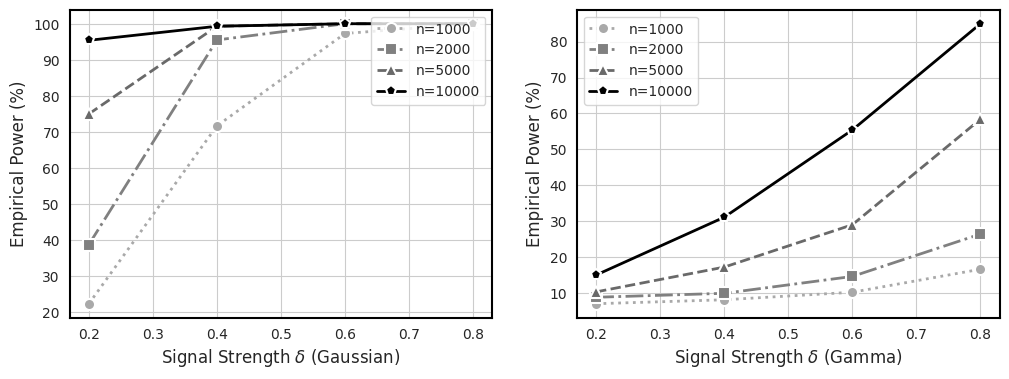

In [347]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(121)
# 输入数据
x = [0.2, 0.4, 0.6, 0.8]
y_n1000 = [22.4,71.7,97.3,100]
y_n2000 = [38.8,95.5,100,100]
y_n5000 = [75,99.3,100,100]
y_n10000 = [95.4,99.3,100,100]
# 绘图
sns.set_style("whitegrid") # 设置背景样式
sns.lineplot(x=x, y=y_n1000, color='darkgray', linewidth=2.0, linestyle = 'dotted', marker="o", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=1000')
sns.lineplot(x=x, y=y_n2000, color='gray', linewidth=2.0,linestyle = 'dashdot', marker="s", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=2000')
sns.lineplot(x=x, y=y_n5000, color='dimgray', linewidth=2.0,linestyle = 'dashed', marker="^", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=5000')
sns.lineplot(x=x, y=y_n10000, color='black', linewidth=2.0, marker="p", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=10000')

# 添加标题和标签
#plt.title("Title", fontweight='bold', fontsize=14)
plt.xlabel('Signal Strength '+r'$\delta$' + ' (Gaussian)', fontsize=12)
plt.ylabel('Empirical Power (%)', fontsize=12)

# 添加图例
plt.legend(loc='upper right', frameon=True, fontsize=10)

# 设置刻度字体和范围
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlim(0, 6)
#plt.ylim(0, 25)

# 设置坐标轴样式
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

#plt.savefig('power_gamma.pdf')#, bbox_inches='tight'
# 显示图像
#plt.show()
plt.grid(True)


plt.subplot(122)
# 输入数据
x = [0.2, 0.4, 0.6, 0.8]
y_n1000 = [7,8.1,10.2,16.6]
y_n2000 = [8.8,9.9,14.6,26.4]
y_n5000 = [10.3,17.2,29,58.4]
y_n10000 = [15,31.1,55.4,85]
# 绘图
sns.set_style("whitegrid") # 设置背景样式
sns.lineplot(x=x, y=y_n1000, color='darkgray', linewidth=2.0, linestyle = 'dotted', marker="o", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=1000')
sns.lineplot(x=x, y=y_n2000, color='gray', linewidth=2.0,linestyle = 'dashdot', marker="s", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=2000')
sns.lineplot(x=x, y=y_n5000, color='dimgray', linewidth=2.0,linestyle = 'dashed', marker="^", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=5000')
sns.lineplot(x=x, y=y_n10000, color='black', linewidth=2.0, marker="p", markersize=8, markeredgecolor="white", markeredgewidth=1.5, label='n=10000')

# 添加标题和标签
#plt.title("Title", fontweight='bold', fontsize=14)
plt.xlabel('Signal Strength '+r'$\delta$' + ' (Gamma)', fontsize=12)
plt.ylabel('Empirical Power (%)', fontsize=12)

# 添加图例
plt.legend(loc='upper left', frameon=True, fontsize=10)

# 设置刻度字体和范围
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlim(0, 6)
#plt.ylim(0, 25)

# 设置坐标轴样式
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.savefig('power_w.pdf')#, bbox_inches='tight'
# 显示图像
plt.show()

# 重复实验

In [493]:
def map_fun(b):
    
    #X0, X1 = simulator_mean(n, p, seed=b)
    X_0, Y_0, Err_0 = simulator(n_0, p, beta, mean, cov, sigma2[0],b)
    X_1, Y_1, Err_1 = simulator(n_1, p, beta, mean, cov, sigma2[1],b+888)
    X0 = np.multiply(X_0,Y_0)
    X1 = np.multiply(X_1,Y_1)
    # 计算Tn
    #SUM0 = 0
    #SAME0 = 0
    #SUM1 = 0
    #SAME1 = 0
    #Jiao = 0
    #for i in range(n):
    #    SAME0 = SAME0 + X0[i,:].T@X0[i,:]
    #    SAME1 = SAME1 + X1[i,:].T@X1[i,:]
    #    for j in range(n):
    #        SUM0 = SUM0 + X0[i,:].T@X0[j,:]
    #        SUM1 = SUM1 + X1[i,:].T@X1[j,:]
    #        Jiao = Jiao + X0[i,:].T@X1[j,:]
    #Tn = (SUM0 - SAME0 + SUM1 - SAME1)/(n*(n-1)) -2*Jiao/n**2
    
    n0 = X0.shape[0]
    n1 = X1.shape[0]
    Tn = np.sum(X0@X0.T/(n0*(n0-1))) + np.sum(X1@X1.T/(n1*(n1-1))) - 2*np.sum(X0@X1.T/(n0*n1)) - np.trace(X0@X0.T/(n0*(n0-1))) - np.trace(X1@X1.T/(n1*(n1-1)))

    
    #print(sigma02_hat[0],sigma12_hat[0])
    sigma_T = sigma_Tn_new(X0,X1)

    T_star = Tn/sigma_T
    print(T_star,sigma_T)
    
    return T_star 

In [462]:
X0@X0.T/(n0*(n0-1))

array([[ 3.09610377e-05,  6.99340089e-07, -9.43102558e-07, ...,
         8.28540994e-07,  1.72514195e-06,  8.72634439e-07],
       [ 6.99340089e-07,  2.87624314e-05, -2.77403940e-06, ...,
         2.91527470e-07,  1.18563482e-06, -2.83670691e-06],
       [-9.43102558e-07, -2.77403940e-06,  2.51406470e-05, ...,
         1.08167237e-06, -4.92571683e-07, -5.12777164e-07],
       ...,
       [ 8.28540994e-07,  2.91527470e-07,  1.08167237e-06, ...,
         2.39034132e-05,  1.00253120e-07,  1.40139608e-06],
       [ 1.72514195e-06,  1.18563482e-06, -4.92571683e-07, ...,
         1.00253120e-07,  2.75603968e-05,  2.48255901e-06],
       [ 8.72634439e-07, -2.83670691e-06, -5.12777164e-07, ...,
         1.40139608e-06,  2.48255901e-06,  2.55275945e-05]])

In [494]:
BB = 1000
T_star_n2000_p500_B1000 = np.zeros(BB)
for b in range(BB):
    print(b)
    T_star_n2000_p500_B1000[b] = map_fun(b) 

0
S00
S11
-0.997209103004757 0.16117179301704226
1
S00
S11
-0.738844427090982 0.15889541976316796
2
S00
S11
-0.8317383555261985 0.17665346586991695
3
S00
S11
-1.1386025287662214 0.14972414036693035
4
S00
S11
-1.1612207978206894 0.16007478279914847
5
S00
S11
-0.75243684238366 0.1646868801204375
6
S00
S11
-0.7767979105836839 0.15694073546988235
7
S00
S11
0.9665443480980429 0.1527161325153274
8
S00
S11
1.5930525968471658 0.15751846640476724
9
S00
S11
-1.0436179798016474 0.1597965303447501
10
S00
S11
-0.10267890539528385 0.15724287058590408
11
S00
S11
-0.7967848703528488 0.16383855120724267
12
S00
S11
-1.1829376702780108 0.1689049894886008
13
S00
S11
0.3060671546178621 0.16150871422540847
14
S00
S11
-0.747702996017782 0.16573229522802704
15
S00
S11
-0.9536146420048474 0.16792627936717872
16
S00
S11
-1.116488004712069 0.17033146482225725
17
S00
S11
-0.23812009241555993 0.15615004695946322
18
S00
S11
1.0782067832229172 0.15649152848391434
19
S00
S11
-1.5382146058911916 0.16475502371040548
20

In [495]:
len(np.where(abs(T_star_n2000_p500_B1000)>1.96)[0])

46

In [496]:
46/1000

0.046